In [84]:
import pandas
import os
import matplotlib.pyplot as plt
import random
import kagglehub
import pandas as pd


#path = kagglehub.dataset_download("shakthisairam123/gym-workout-imu-dataset")
path = "data"

In [85]:
#checking data without filtering
data = []
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        data.append(pd.read_csv(os.path.join(dirname, filename)))

print(data[0].keys())
data[0].head()



Index(['secondsElapsed', 'wristMotion_rotationRateX',
       'wristMotion_rotationRateY', 'wristMotion_rotationRateZ',
       'wristMotion_gravityX', 'wristMotion_gravityY', 'wristMotion_gravityZ',
       'wristMotion_accelerationX', 'wristMotion_accelerationY',
       'wristMotion_accelerationZ', 'wristMotion_quaternionW',
       'wristMotion_quaternionX', 'wristMotion_quaternionY',
       'wristMotion_quaternionZ', 'weight', 'set', 'reps', 'activity',
       'activityEncoded'],
      dtype='object')


,secondsElapsed,wristMotion_rotationRateX,wristMotion_rotationRateY,wristMotion_rotationRateZ,wristMotion_gravityX,wristMotion_gravityY,wristMotion_gravityZ,wristMotion_accelerationX,wristMotion_accelerationY,wristMotion_accelerationZ,wristMotion_quaternionW,wristMotion_quaternionX,wristMotion_quaternionY,wristMotion_quaternionZ,weight,set,reps,activity,activityEncoded
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0,15.0,CGCR,2
1,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0,15.0,CGCR,2
2,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0,15.0,CGCR,2
3,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0,15.0,CGCR,2
4,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,1.0,15.0,CGCR,2


Preparing data for training

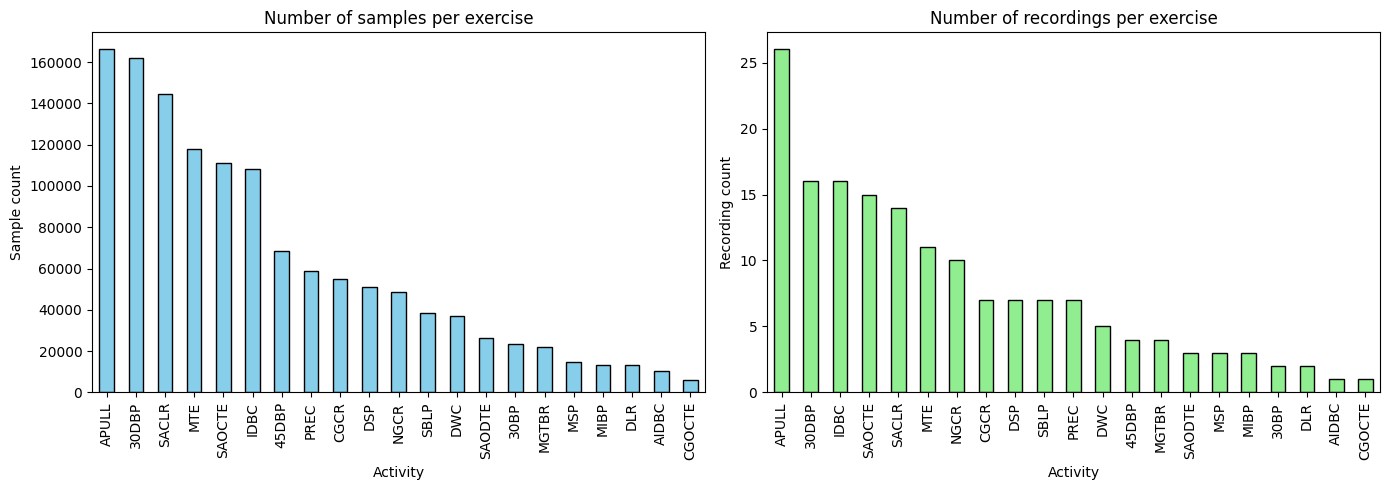

In [86]:
def plots():
    all_data = pd.concat(data, ignore_index=True)

    sample_counts = all_data["activity"].value_counts()
    recording_counts = pd.Series([df["activity"].iloc[0] for df in data]).value_counts()


    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    
    # Samples per exercise(How many data points each exercise has)
    sample_counts.plot(kind="bar", ax=axes[0], color="skyblue", edgecolor="black")
    axes[0].set_title("Number of samples per exercise")
    axes[0].set_xlabel("Activity")
    axes[0].set_ylabel("Sample count")
    axes[0].tick_params(axis="x", rotation=90)
    
    # Recordings per execise(How many times exercise was done)
    recording_counts.plot(kind="bar", ax=axes[1], color="lightgreen", edgecolor="black")
    axes[1].set_title("Number of recordings per exercise")
    axes[1].set_xlabel("Activity")
    axes[1].set_ylabel("Recording count")
    axes[1].tick_params(axis="x", rotation=90)
    
    plt.tight_layout()
    plt.show()
    
plots()

    

In [87]:
#first and last values are empty for each file, also only used will be gyroscope and accelerometer data, everything else is dropped here
def filter_data(df):
    df_filtered = df.copy()
    min_time = df_filtered["secondsElapsed"].min() + 1.5
    max_time = df_filtered["secondsElapsed"].max() - 1.5
    df_filtered = df_filtered[(df_filtered["secondsElapsed"] >= min_time) & (df_filtered["secondsElapsed"] <= max_time)].reset_index(drop=True)
    df_filtered = df_filtered.drop(
    columns=[
        "wristMotion_gravityX",
        "wristMotion_gravityY",
        "wristMotion_gravityZ",
        "wristMotion_quaternionW",
        "wristMotion_quaternionX",
        "wristMotion_quaternionY",
        "wristMotion_quaternionZ",
        #"weight",
        #"set",
        #"reps",
        #"activity",
        #"activityEncoded",
    ],
    
    )
    return df_filtered


# Smooth noisy sensor signals using a moving average.
def smooth_columns(df, window):
    df_smoothed = df.copy()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            df_smoothed[col] = df[col].rolling(window=window, center=True).mean()
    return df_smoothed



In [88]:
#loading data with filtering
import pandas as pd
import os

data_list = []  # will store filtered DataFrames
activity_list = []  # will store activity per file

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        df = pd.read_csv(os.path.join(dirname, filename))
        df_filtered = filter_data(df)
        if not df_filtered.empty and 'activity' in df_filtered.columns:
            data_list.append(df_filtered)
            # store activity for this recording (assume all rows in a file have the same activity)
            activity_list.append(df_filtered['activity'].iloc[0])


# Count how many recordings exist per activity
activity_counts = pd.Series(activity_list).value_counts()

# Keep only activities with more than 8 recordings (for now)
valid_activities = activity_counts[activity_counts > 8].index

filtered_data_list = []
for df in data_list:
    if df['activity'].iloc[0] in valid_activities:
        filtered_data_list.append(df)


#time, rotations(X,Y,Z), acceleration(X,Y,Z), 'weight', 'set', 'reps', 'activity', 'activityEncoded'

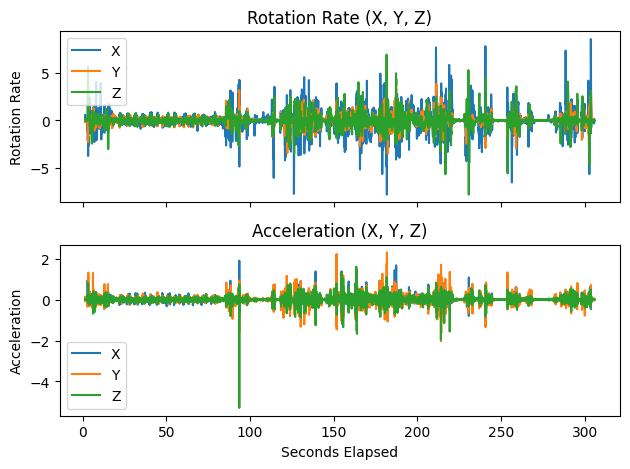

In [89]:
#Checking random sample
data = filtered_data_list
n = random.randint(0, len(data) - 1)
df = data[n]

#df = smooth_columns(df, 5) #smoothing window Works better without this

fig, axes = plt.subplots(2,1,sharex = True)

#gyroscope data
axes[0].plot(df["secondsElapsed"], df["wristMotion_rotationRateX"], label="X")
axes[0].plot(df["secondsElapsed"], df["wristMotion_rotationRateY"], label="Y")
axes[0].plot(df["secondsElapsed"], df["wristMotion_rotationRateZ"], label="Z")
axes[0].set_ylabel("Rotation Rate")
axes[0].set_title("Rotation Rate (X, Y, Z)") 
axes[0].legend()

#accelerometer data
axes[1].plot(df["secondsElapsed"], df["wristMotion_accelerationX"], label="X")
axes[1].plot(df["secondsElapsed"], df["wristMotion_accelerationY"], label="Y")
axes[1].plot(df["secondsElapsed"], df["wristMotion_accelerationZ"], label="Z")
axes[1].set_ylabel("Acceleration")
axes[1].set_xlabel("Seconds Elapsed")
axes[1].set_title("Acceleration (X, Y, Z)")
axes[1].legend()

plt.tight_layout()
plt.show()

Label encoding. Each label gets a corresponding id

In [90]:
#Gives each activity ID
all_activities = pd.concat([df['activity'] for df in data], ignore_index=True)

#activity mapping
categories = all_activities.astype("category").cat.categories
activity_to_id = {cat: idx for idx, cat in enumerate(categories)}

print(activity_to_id)
#gives new column activity encoded to each df
for i, df in enumerate(data):
    df["activityEncoded"] = df["activity"].map(activity_to_id)
    data[i] = df

{'30DBP': 0, 'APULL': 1, 'IDBC': 2, 'MTE': 3, 'NGCR': 4, 'SACLR': 5, 'SAOCTE': 6}


In [91]:
imu_features = [
    "wristMotion_rotationRateX", "wristMotion_rotationRateY", "wristMotion_rotationRateZ",
    "wristMotion_accelerationX", "wristMotion_accelerationY", "wristMotion_accelerationZ"
]

In [92]:
import numpy as np

#checking for NaN in data
for i, df in enumerate(data):
    df[imu_features] = df[imu_features].fillna(0).replace([np.inf, -np.inf], 0)
    data[i] = df
        

In [93]:
import torch

#Select Gpu
device = torch.device("cuda")


In [94]:
def preprocess_sample(window ,y, smooth_kernel=5, downsample_factor=2, downsample_mode="avg"):

    X = window.astype(np.float32)

    #1. Creates a smoothing kernel
    if smooth_kernel and smooth_kernel > 1:
        k = int(smooth_kernel)
        if k % 2 == 0:
             k += 1 #enforce odd

        kernel = np.ones(k, dtype=np.float32) / k
        X = np.vstack([
            np.convolve(X[:, f], kernel, mode="same")
            for f in range(X.shape[1])
        ]).T.astype(np.float32)


   
    #2. Downsample
    if downsample_factor and downsample_factor > 1:
        d = int(downsample_factor)
        if downsample_mode == "avg":
            T, F = X.shape
            # pad to make T divisible by d (repeat last row)
            pad_needed = (-T) % d
            if pad_needed:
                X = np.concatenate([X, np.repeat(X[-1:, :], pad_needed, axis=0)], axis=0)
            X = X.reshape(-1, d, F).mean(axis=1)
        else:  # "slice"
            X = X[::d]

    return X, y


In [95]:
from torch.utils.data import Dataset

class IMUDataset(Dataset):
    def __init__(self, dataframes, features, window_size=300, step_size=150,
                 preprocess_fn=None, preprocess_kwargs=None):
        """
        dataframes: list of pandas DataFrames
        features: list of feature column names to use
        window_size: number of timesteps per window (e.g. 300 = 3s at 100Hz)
        step_size: overlap between windows (e.g. 150 = 50% overlap)
        """
        self.samples = []
        self.preprocess_fn = preprocess_fn
        self.preprocess_kwargs = preprocess_kwargs or {}

        for df in dataframes: #each file is a dataframe 
            X = df[features].values #X values for one dataframe
            y = int(df["activityEncoded"].iloc[0])  # same label for the whole sequence

            for start in range(0, len(X) - window_size + 1, step_size):
                end = start + window_size
                window = X[start:end]


                #What is happening here?
                if self.preprocess_fn is not None:
                    window, y_out = self.preprocess_fn(window, y, **self.preprocess_kwargs) #applying preprocessing function
                    y_use = y_out #preprocessed
                else:
                    y_use = y #not preprocessed

                self.samples.append((window, y_use)) #appending every window + corresponding activity

    def __len__(self):
        return len(self.samples) #number of windows gathered

    def __getitem__(self, idx):
        X, y = self.samples[idx]
        X = torch.tensor(X, dtype=torch.float32)  # (window_size, num_features)
        y = torch.tensor(y, dtype=torch.long)     # Class
        return X, y

Implementing StratifiedShuffleSplit
Dont understand this part
Used for dividing train/test for time series data

In [96]:

from sklearn.model_selection import StratifiedShuffleSplit
import warnings

# Changing window size could improve accuracy TODO
window_size = 300                 # timesteps per window 
step_size = 30                   # overlap between windows 
train_split = 0.8


#What is happening here?
session_labels = np.array([int(df["activityEncoded"].iloc[0]) for df in data])
n_sessions = len(data)
target_train = int(train_split * n_sessions)

def stratified_session_split(data, labels, train_ratio=0.8, seed=42):
    labels = np.asarray(labels)
    idx_all = np.arange(len(labels))

    # Classes with only 1 session cannot be stratified -> force them into TRAIN
    _, counts = np.unique(labels, return_counts=True)
    cls_counts = dict(zip(*np.unique(labels, return_counts=True)))
    rare_classes = {c for c, k in cls_counts.items() if k < 2}

    forced_train_idx = np.array([i for i in idx_all if labels[i] in rare_classes], dtype=int)
    rest_idx = np.array([i for i in idx_all if labels[i] not in rare_classes], dtype=int)

    if len(rest_idx) == 0:
        warnings.warn("All classes are rare (count<2). Putting all sessions in TRAIN.")
        return forced_train_idx, np.array([], dtype=int)

    # Desired train size for the remaining pool
    remaining_train_needed = max(0, target_train - len(forced_train_idx))
    remaining_total = len(rest_idx)

    if remaining_total == 0 or remaining_train_needed == 0:
        train_idx = forced_train_idx
        test_idx = np.setdiff1d(idx_all, train_idx, assume_unique=False)
        return np.sort(train_idx), np.sort(test_idx)

    # Compute adjusted test_size for the remaining pool
    adjusted_train_ratio = min(1.0, remaining_train_needed / remaining_total)
    adjusted_test_size = 1.0 - adjusted_train_ratio

    # Stratified split on the remaining pool
    sss = StratifiedShuffleSplit(n_splits=1, test_size=adjusted_test_size, random_state=seed)
    rest_labels = labels[rest_idx]
    (rest_train_sel, rest_test_sel), = sss.split(rest_idx, rest_labels)

    train_idx = np.concatenate([forced_train_idx, rest_idx[rest_train_sel]])
    test_idx  = rest_idx[rest_test_sel]

    # Safety: ensure every class present in the whole dataset appears in TRAIN
    present_all = set(np.unique(labels))
    present_train = set(np.unique(labels[train_idx]))
    missing_in_train = present_all - present_train
    if missing_in_train:
        warnings.warn(f"Some classes had too few sessions; moving one session per missing class to TRAIN: {missing_in_train}")
        for cls in list(missing_in_train):
            cand = np.where(labels[test_idx] == cls)[0]
            if len(cand) > 0:
                move = test_idx[cand[0]]
                train_idx = np.append(train_idx, move)
                test_idx = np.delete(test_idx, cand[0])

    return np.sort(train_idx), np.sort(test_idx)



# ---- use the splitter ----
train_idx, test_idx = stratified_session_split(data, session_labels, train_ratio=train_split, seed=42)
train_dfs = [data[i] for i in train_idx]
test_dfs  = [data[i] for i in test_idx]

print(f"Sessions -> train: {len(train_dfs)} | test: {len(test_dfs)}")
# Quick distribution check
test_classes = sorted({int(df['activityEncoded'].iloc[0]) for df in test_dfs})
train_classes = sorted({int(df['activityEncoded'].iloc[0]) for df in train_dfs})
missing_in_test = sorted(set(train_classes) - set(test_classes))
print(f"Train classes ({len(train_classes)}):", train_classes)
print(f"Test classes ({len(test_classes)}):", test_classes, "\nMissing in test:", missing_in_test) 

Sessions -> train: 86 | test: 22
Train classes (7): [0, 1, 2, 3, 4, 5, 6]
Test classes (7): [0, 1, 2, 3, 4, 5, 6] 
Missing in test: []


In [97]:


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader


# 2) Fit scaler ONLY on TRAIN using a DataFrame 
scaler = StandardScaler()
train_stack_df = pd.concat([df.loc[:, imu_features] for df in train_dfs], ignore_index=True)
scaler.fit(train_stack_df)   

# 3) Transform in place (preserve column order and names)
for df in train_dfs:
    df.loc[:, imu_features] = scaler.transform(df.loc[:, imu_features])

for df in test_dfs:
    df.loc[:, imu_features] = scaler.transform(df.loc[:, imu_features])



# 4) Build datasets (one per split) from the pre-scaled DataFrames
train_dataset = IMUDataset(
    dataframes=train_dfs,
    features=imu_features,
    window_size=window_size,
    step_size=step_size,
    preprocess_fn=preprocess_sample,
    preprocess_kwargs=dict(smooth_kernel=5, downsample_factor=2, downsample_mode="avg")
)

test_dataset = IMUDataset(
    dataframes=test_dfs,
    features=imu_features,
    window_size=window_size,
    step_size=step_size,
    preprocess_fn=preprocess_sample,   
    preprocess_kwargs=dict(smooth_kernel=5, downsample_factor=2, downsample_mode="avg")
)

# 5) DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1,  shuffle=False)

#what does this do?
assert set(map(id, train_dfs)).isdisjoint(set(map(id, test_dfs))), "Leak: same session in both splits"



In [98]:
print("Train dataset size:", len(train_dataset))

X, y = train_dataset[0]
print("X shape:", X.shape)   # (window_size, num_features)
print("y:", y)               # label

for X, y in train_loader:
    print("Batch X shape:", X.shape)   # (batch_size, window_size, num_features)
    print("Batch y shape:", y.shape)   # (batch_size,)
    break

#Test dataset info
print("Test dataset size:", len(test_dataset))
X, y = test_dataset[0]
print("X shape:", X.shape)   # (window_size, num_features)
print("y:", y)               # label

for X, y in test_loader:
    print("Batch X shape:", X.shape)   # (batch_size, window_size, num_features) or (batch_size, timesteps, channels)
    print("Batch y shape:", y.shape)   # (batch_size,)
    break

Train dataset size: 20567
X shape: torch.Size([150, 6])
y: tensor(6)
Batch X shape: torch.Size([32, 150, 6])
Batch y shape: torch.Size([32])
Test dataset size: 5953
X shape: torch.Size([150, 6])
y: tensor(2)
Batch X shape: torch.Size([1, 150, 6])
Batch y shape: torch.Size([1])


Adding weights to imbalanced data

In [99]:
from sklearn.utils.class_weight import compute_class_weight


y_train = [train_dataset[i][1].item() for i in range(len(train_dataset))]
id_to_activity = dict(enumerate(categories))


classes = np.array(sorted(id_to_activity.keys()))


class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)



class_weights = torch.tensor(class_weights_np, dtype=torch.float32, device='cuda')


class_counts = np.bincount(y_train, minlength=classes.max() + 1)

df_weights = pd.DataFrame({
    "Class ID": classes,
    "Activity": [id_to_activity[i] for i in classes],
    "Count": class_counts[classes],     # index by 'classes' to stay aligned
    "Weight": class_weights_np
}).sort_values("Weight", ascending=False, ignore_index=True)

print(df_weights)





   Class ID Activity  Count    Weight
0         4     NGCR   1140  2.577318
1         5    SACLR   2646  1.110409
2         2     IDBC   2669  1.100840
3         6   SAOCTE   2783  1.055747
4         3      MTE   3207  0.916166
5         1    APULL   3984  0.737486
6         0    30DBP   4138  0.710039


In [100]:
num_features = len(imu_features)

num_classes = len(activity_to_id)

learning_rate = 2e-4
num_epochs = 50

#model parameters
hidden_dim = 64
lstm_layers = 2

#regularization
clip_grad_norm = 1.0





MODEL

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()

        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        return F.relu(out)
    
class Attention(nn.Module):
    def __init__(self, hidden_size):
            super().__init__()
            self.score = nn.Linear(hidden_size, 1)

    def forward(self, x):
            # x: (batch, time, features)
            weights = torch.softmax(self.score(x), dim=1)
            attended = x * weights
            return attended.sum(dim=1)

Training loop

In [102]:
class IMUModel(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()

        # CNN expects (B, C, T)
        self.conv_in = nn.Conv1d(n_channels, 64, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(64)

        self.res1 = ResidualBlock(64, 64)
        self.res2 = ResidualBlock(64, 128)

        self.dropout = nn.Dropout(0.3)

        # GRU
        self.gru = nn.GRU(
            input_size=128,
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )

        self.attention = Attention(128)

        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        # x: (B, T, C) → (B, C, T)
        x = x.permute(0, 2, 1)

        x = F.relu(self.bn(self.conv_in(x)))
        x = self.res1(x)
        x = self.res2(x)

        x = self.dropout(x)

        # back to (B, T, C)
        x = x.permute(0, 2, 1)

        x, _ = self.gru(x)

        x = self.attention(x)

        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.4, training=self.training)

        return self.fc2(x)

In [103]:
model = IMUModel(
    n_channels=X.shape[2],
    n_classes=num_classes
).to(device)

In [104]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.RAdam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=5
)

In [105]:
best_val_loss = float("inf")
patience = 5
trigger_times = 0
best_val_acc = 0.0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(50):
    correct = 0
    total = 0
    running_loss = 0.0

    model.train() #sets model to training mode
    for X,y in train_loader:
        X, y = X.to(device), y.to(device) #move to gpu
        optimizer.zero_grad() #sets gradients to zero
        #Forward 
        outputs = model(X)
        #Loss
        loss = criterion(outputs, y)
        # Skip batch if loss is NaN
        if torch.isnan(loss):
            print("NaN detected! Skipping batch.")
            continue

        #Backward
        loss.backward()

        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
        #updates parameters
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs,dim=1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    #test accuracy
    epoch_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch {epoch}: loss={avg_loss:.4f}, accuracy={epoch_acc:.2f}%")

    #validation accuracy
    model.eval() #sets model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device) 
            outputs_val = model(X_val)
            loss_val = criterion(outputs_val, y_val)
            val_loss += loss_val.item()
            _, predicted_val = torch.max(outputs_val, dim=1)
            val_correct += (predicted_val == y_val).sum().item()
            val_total += y_val.size(0)

    val_loss /= len(test_loader)
    val_acc = 100 * val_correct / val_total
 

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Validation: loss={val_loss:.4f}, accuracy={val_acc:.2f}%")

    # early stopping logic with val_loss improvement check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # saves the best model
        torch.save(model.state_dict(), "best_model_CNN+GRU.pt")
    else:
        trigger_times += 1
        print(f"No improvement in validation loss. Trigger times: {trigger_times}")
        if trigger_times >= patience:
            print("Early stopping!")
            break





Epoch 0: loss=0.6620, accuracy=78.86%
Validation: loss=1.0599, accuracy=79.22%
Epoch 1: loss=0.2795, accuracy=90.75%
Validation: loss=1.0844, accuracy=80.30%
No improvement in validation loss. Trigger times: 1
Epoch 2: loss=0.2145, accuracy=93.09%
Validation: loss=1.2506, accuracy=79.56%
No improvement in validation loss. Trigger times: 2
Epoch 3: loss=0.1771, accuracy=94.25%
Validation: loss=1.2329, accuracy=81.86%
No improvement in validation loss. Trigger times: 3
Epoch 4: loss=0.1482, accuracy=95.10%
Validation: loss=1.2750, accuracy=81.03%
No improvement in validation loss. Trigger times: 4
Epoch 5: loss=0.1215, accuracy=96.03%
Validation: loss=1.5974, accuracy=76.28%
No improvement in validation loss. Trigger times: 5
Early stopping!


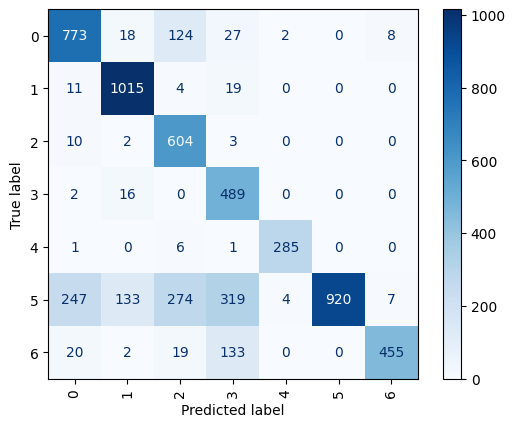

In [106]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

device = torch.device("cuda")
model = model.to(device)  

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1)

        y_true.extend(y.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=90)
plt.show()

In [107]:
labels_present = sorted(set(y_true) | set(y_pred))
target_names = [id_to_activity[i] if i < len(id_to_activity) else f"class_{i}" for i in labels_present]

print(classification_report(
    y_true, y_pred,
    labels=labels_present,
    target_names=target_names,
    zero_division=0
))


              precision    recall  f1-score   support

       30DBP       0.73      0.81      0.77       952
       APULL       0.86      0.97      0.91      1049
        IDBC       0.59      0.98      0.73       619
         MTE       0.49      0.96      0.65       507
        NGCR       0.98      0.97      0.98       293
       SACLR       1.00      0.48      0.65      1904
      SAOCTE       0.97      0.72      0.83       629

    accuracy                           0.76      5953
   macro avg       0.80      0.84      0.79      5953
weighted avg       0.84      0.76      0.76      5953

